# Atmospheric composition distribution by CAMS and GOME-2

### Main goal:
* Compare GOME-2 and CAMS datasets for NO<sub>2</sub> (Level 3).

## Imports and supporting functions

In [1]:
import os 
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import xarray as xr
import pandas as pd
import numpy as np
from itertools import product
import scipy.interpolate
from copy import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import math
import geojson
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist
import datetime as dt
import wget # Important for GOME-2
import subprocess # Important for GOME-2
import geocoder
import seaborn as sns

In [2]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_gome.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

## 1. Define datasets

In [4]:
component_nom = 'NO2'

sensor = 'gome'
sensor_type = 'L3'
satellites = ['A', 'B']

model = 'cams'
model_full_name = 'cams-global-reanalysis-eac4-monthly'

# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(sensor, component_nom)

# Folders generation
generate_folders(model, sensor, component_nom)

The comparison is possible and will start now.


In [5]:
# Define extent
lon_min = -20
lon_max = 40
lat_min = 30
lat_max = 70    

# Create bbox
bbox = ((lon_min, lat_min), (lon_max, lat_max))

# Define search period
start_date = '2016-08-01'
end_date = '2016-10-31'
dates = search_period(start_date, end_date, sensor, sensor_type)

SEARCH PERIOD
- In months: ('2016-08', '2016-09', '2016-10')


## 2. Model data

### Download, read and subset data as xarray

In [6]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               model_full_name, model_level = 'Single')
model_ds, dates = CAMS_read(model_product_name, component, component_nom, dates)
model_ds = subset(model_ds, bbox)
model_ds

The file exists, it will not be downloaded again.


<xarray.Dataset>
Dimensions:     (latitude: 54, longitude: 81, time: 3)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2016-08-01 2016-09-01 2016-10-01
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 30.0 30.75 31.5 32.25 ... 68.25 69.0 69.75
  * longitude   (longitude) float64 -20.25 -19.5 -18.75 ... 38.25 39.0 39.75
    valid_time  (time) datetime64[ns] ...
Data variables:
    component   (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-16T18:47 GRIB to CDM+CF via cfgrib-0.9.9...

### Convert CAMS data units (kg/m2 to molecules/cm<sup>2</sup>)

In [7]:
model_ds, units = model_convert_units(model_ds, model, component_mol_weight, component, conversion_method = 'Simple')

The model component units have been converted from kg m**-2 to molec cm-2.


## 3. Sensor data

### Collect and read data as xarray

In [8]:
sensor_product_names = sensor_download(sensor, sensor_type, component_nom)

File 'data/gome/NO2/monthly/A/GOME_NO2_Global_201608_METOPA_DLR_v1.nc' already there; not retrieving.
File 'data/gome/NO2/monthly/B/GOME_NO2_Global_201608_METOPB_DLR_v1.nc' already there; not retrieving.
File 'data/gome/NO2/monthly/A/GOME_NO2_Global_201609_METOPA_DLR_v1.nc' already there; not retrieving.
File 'data/gome/NO2/monthly/B/GOME_NO2_Global_201609_METOPB_DLR_v1.nc' already there; not retrieving.
File 'data/gome/NO2/monthly/A/GOME_NO2_Global_201610_METOPA_DLR_v1.nc' already there; not retrieving.
File 'data/gome/NO2/monthly/B/GOME_NO2_Global_201610_METOPB_DLR_v1.nc' already there; not retrieving.


In [9]:
sensor_ds, _, _ = sensor_read(sensor, sensor_type, component_nom, dates, sensor_column, satellites)
sensor_ds

<xarray.Dataset>
Dimensions:    (latitude: 4320, longitude: 1440, time: 3)
Coordinates:
  * time       (time) datetime64[ns] 2016-08-01 2016-09-01 2016-10-01
  * latitude   (latitude) float64 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    NO2total   (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    description:  Level 3 NO2 data
    Conventions:  CF-1.6

## 4. Match data (and apply averaging kernels)

In [10]:
kernels_method = None
match_table = generate_match_table(sensor_ds, model_ds, bbox, kernels_method, 
                                   sensor, component_nom, sensor_column)
match_table

FOR MONTH: 2016-08
The dataset does not contain data to apply the averaging kernels.
The model does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.
FOR MONTH: 2016-09
The dataset does not contain data to apply the averaging kernels.
The model does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.
FOR MONTH: 2016-10
The dataset does not contain data to apply the averaging kernels.
The model does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.


,latitude,longitude,time,NO2total,model_column
0,29.875,-20.125,2016-08-01,2.855279e+15,1.907574e+15
1,29.875,-19.875,2016-08-01,2.840513e+15,1.920713e+15
2,29.875,-19.625,2016-08-01,2.820857e+15,1.920713e+15
3,29.875,-19.375,2016-08-01,2.750407e+15,1.920713e+15
4,29.875,-19.125,2016-08-01,2.698635e+15,1.944178e+15
...,...,...,...,...,...
38796,69.875,38.875,2016-10-01,3.775183e+15,1.574207e+15
38797,69.875,39.125,2016-10-01,3.801560e+15,1.574207e+15
38798,69.875,39.375,2016-10-01,3.822376e+15,1.532487e+15
38799,69.875,39.625,2016-10-01,3.852133e+15,1.532487e+15


## 5. Merge data and calculate difference

In [11]:
merge_table = generate_merge_table(match_table, sensor_ds, model_ds, kernels_method, sensor_column, sensor)
merge_table

NO2total  model_column    difference
latitude longitude time                                                
29.875   -20.125   2016-08-01  2.855279e+15  1.907574e+15  9.477048e+14
                   2016-09-01  2.855279e+15  1.723524e+15  1.131756e+15
                   2016-10-01  2.855279e+15  1.536368e+15  1.318912e+15
         -19.875   2016-08-01  2.840513e+15  1.920713e+15  9.198000e+14
                   2016-09-01  2.840513e+15  1.735472e+15  1.105041e+15
...                                     ...           ...           ...
69.875    39.625   2016-09-01  3.852133e+15  1.429478e+15  2.422655e+15
                   2016-10-01  3.852133e+15  1.532487e+15  2.319646e+15
          39.875   2016-08-01  3.826060e+15  1.429753e+15  2.396307e+15
                   2016-09-01  3.826060e+15  1.429478e+15  2.396583e+15
                   2016-10-01  3.826060e+15  1.532487e+15  2.293574e+15

[116403 rows x 3 columns]

In [12]:
descr_statistics_table = merge_table.describe()
descr_statistics_table

,NO2total,model_column,difference
count,1.164030e+05,1.164030e+05,1.164030e+05
mean,3.607515e+15,3.018427e+15,5.890880e+14
std,3.092423e+14,1.512487e+15,1.386526e+15
min,2.644706e+15,9.515554e+14,-1.526065e+16
25%,3.420531e+15,1.916395e+15,3.692585e+13
50%,3.636396e+15,2.705999e+15,8.497773e+14
75%,3.775024e+15,3.676225e+15,1.429878e+15
max,8.678358e+15,1.922112e+16,3.216465e+15


## 6. Show comparison plots

### Select plot dates

In [13]:
plot_dates = plot_period(sensor_ds, sensor)

The plots will be shown for the following dates:
['2016-08' '2016-09' '2016-10']


### Select plot extent

In [14]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((-20, 30), (40, 70))


### Compare CAMS and GOME-2 total columns

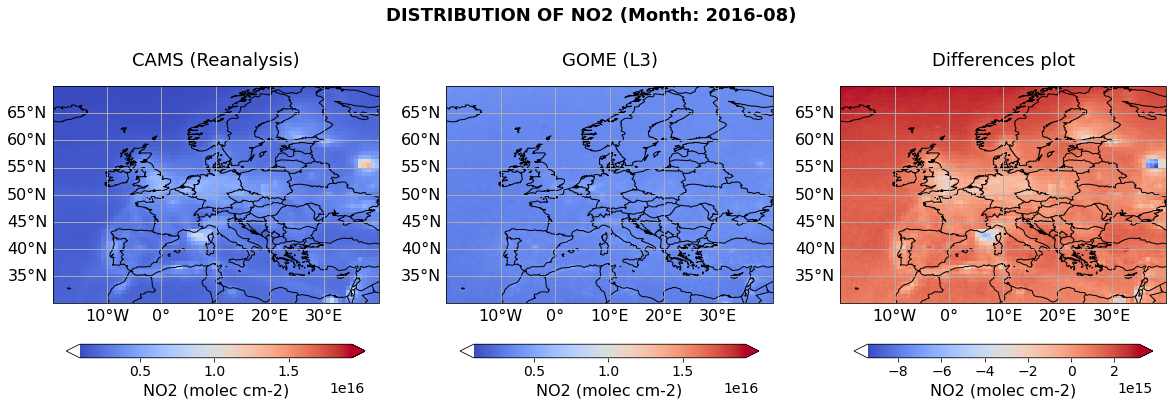

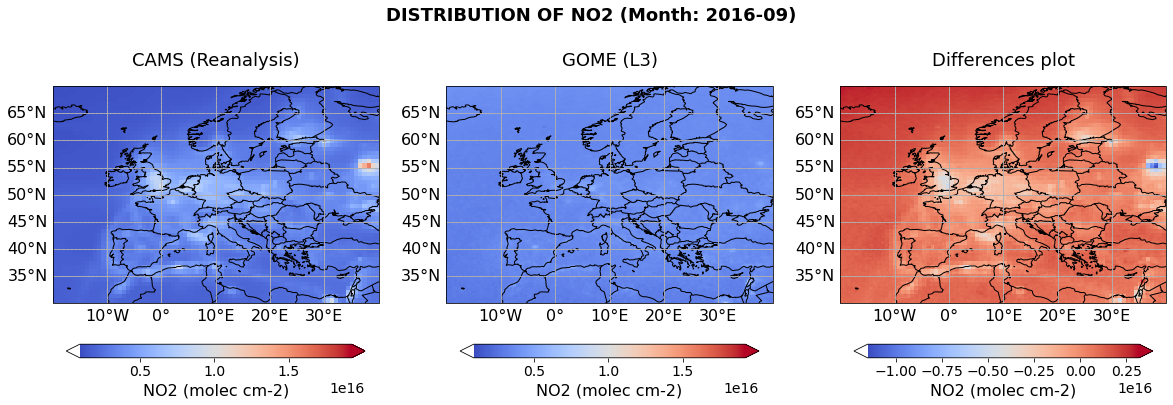

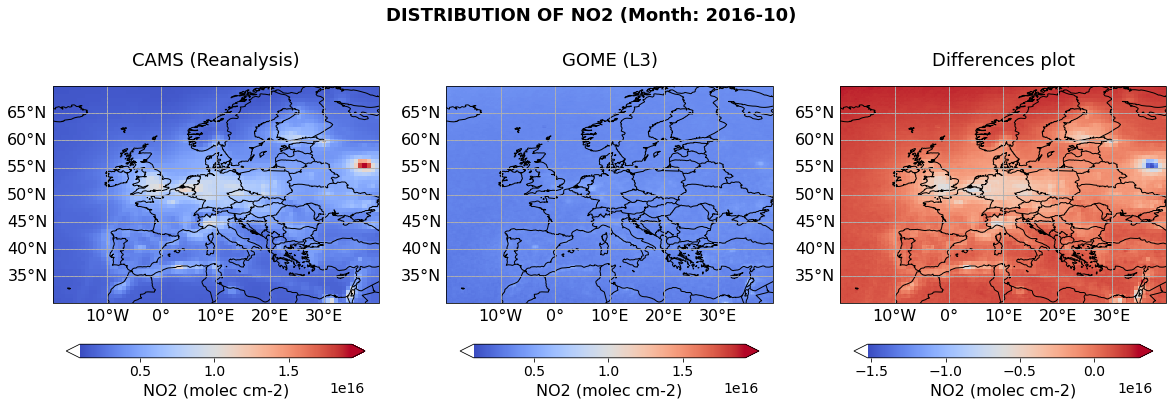

In [15]:
range_type = 'equal' # original, positive or equal
distribution_type = 'individual' # aggregated or individual

projection = ccrs.PlateCarree()
color_scale = 'coolwarm'

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_table, plot_dates, plot_bbox, 20, 1.10, 
                          model_type, sensor_type, range_type, sensor_column, distribution_type, projection,
                          color_scale)

## 7. Retrieve nearest values to specific latitude and longitude

NO2total  \
lat_search lon_search latitude longitude time                       
50         60         49.875   39.875    2016-08-01  3.740587e+15   
                                         2016-09-01  3.740587e+15   
                                         2016-10-01  3.740587e+15   
4          10         29.875   9.875     2016-08-01  3.111040e+15   
                                         2016-09-01  3.111040e+15   
                                         2016-10-01  3.111040e+15   
20         30         29.875   29.875    2016-08-01  3.427416e+15   
                                         2016-09-01  3.427416e+15   
                                         2016-10-01  3.427416e+15   

                                                     model_column  \
lat_search lon_search latitude longitude time                       
50         60         49.875   39.875    2016-08-01  3.154404e+15   
                                         2016-09-01  4.189408e+15   
                                         2016-10-01  4.021864e+15   
4          10         29.875   9.875     2016-08-01  2.287335e+15   
                                         2016-09-01  1.981625e+15   
                                         2016-10-01  1.736399e+15   
20         30         29.875   29.875    2016-08-01  3.599169e+15   
                                         2016-09-01  4.120429e+15   
                                         2016-10-01  4.179684e+15   

                                                       difference  
lat_search lon_search latitude longitude time                      
50         60         49.875   39.875    2016-08-01  5.861830e+14  
                                         2016-09-01 -4.488211e+14  
                                         2016-10-01 -2.812774e+14  
4          10         29.875   9.875     2016-08-01  8.237047e+14  
                                         2016-09-01  1.129415e+15  
                                         2016-10-01  1.374641e+15  
20         30         29.875   29.875    2016-08-01 -1.717528e+14  
                                         2016-09-01 -6.930123e+14  
                                         2016-10-01 -7.522675e+14

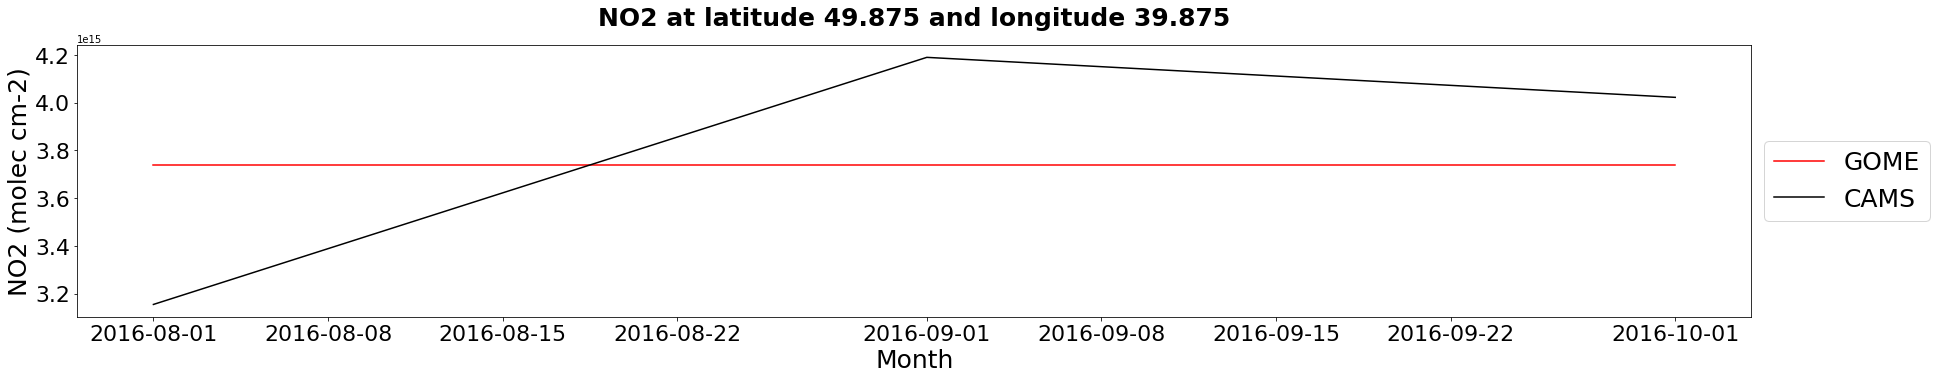

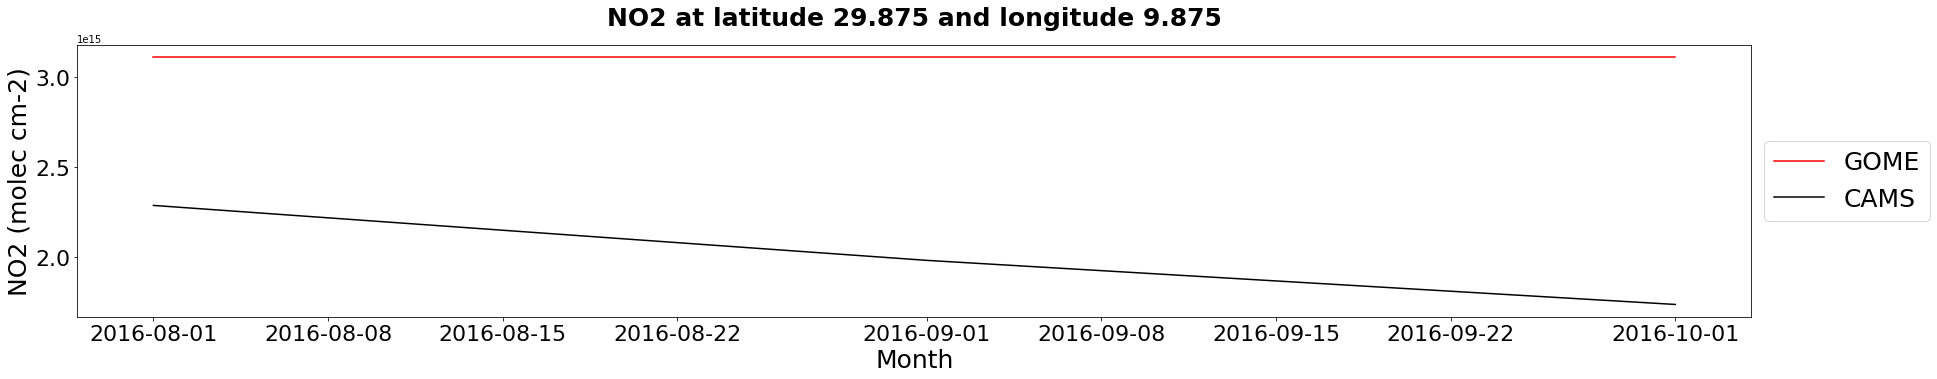

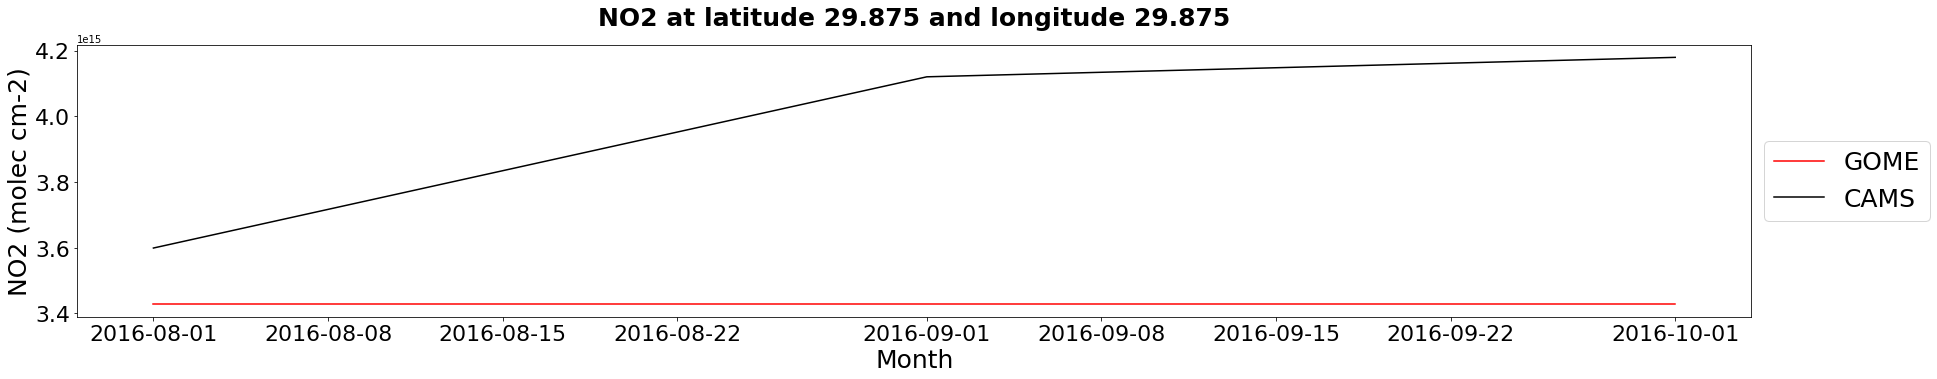

In [16]:
coords_search_list = (50, 60,
                      4, 10,
                      20, 30)
coords_search = pairwise(coords_search_list)
retrieval_table_all =  retrieve_coords(merge_table.dropna(), coords_search, component_nom, 
                                       sensor_column, sensor, model, plot_dates, units)
retrieval_table_all

## 8. Scatter plots by bbox

Fit equation: NO2_model = NO2_sensor * 2.41 + (-5.67E+15)
Coefficient of determination (R2): 0.24


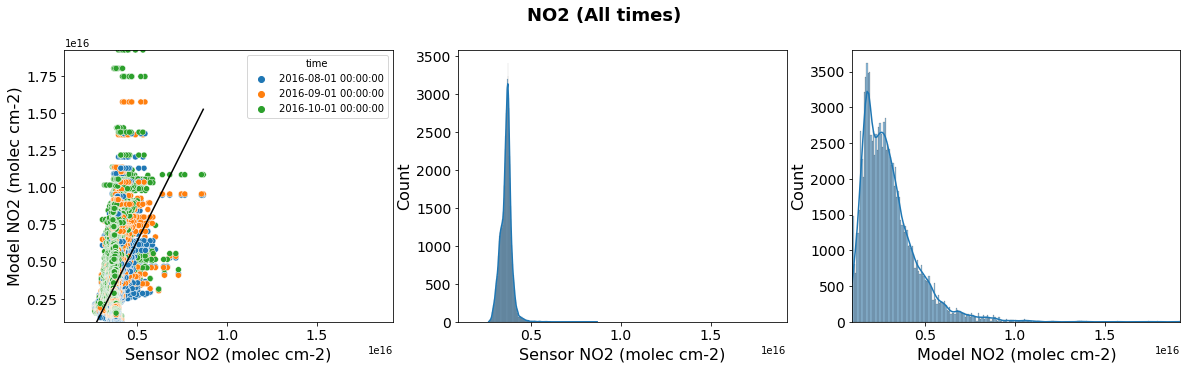

In [17]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual
summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, 
                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, plot_bbox)

In [18]:
summary

,Period,Location,Score,Coefficient,Intercept
0,"[2016-08-01T00:00:00.000000000, 2016-09-01T00:...","((-20, 30), (40, 70))",0.242643,2.409219,-5.672866e+15


## 9. Scatter plots by season

Fit equation: NO2_model = NO2_sensor * 2.03 + (-4.56E+15)
Coefficient of determination (R2): 0.25


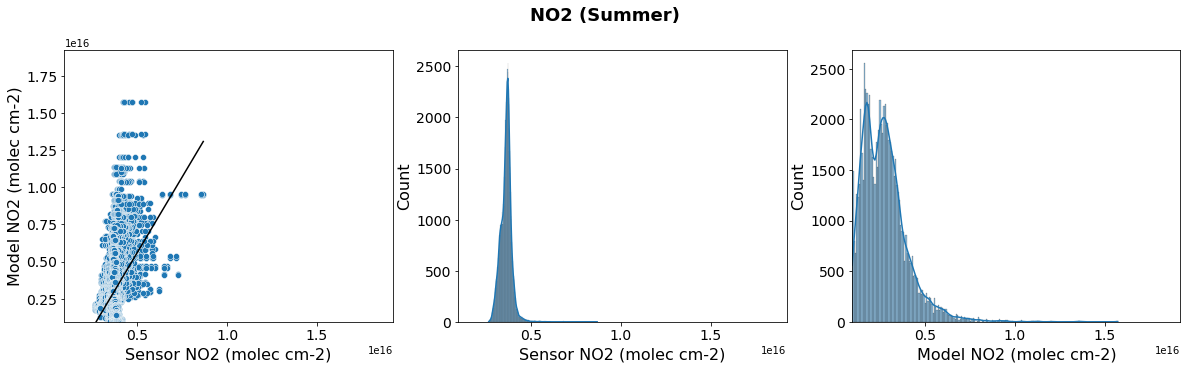

Fit equation: NO2_model = NO2_sensor * 3.16 + (-7.89E+15)
Coefficient of determination (R2): 0.29


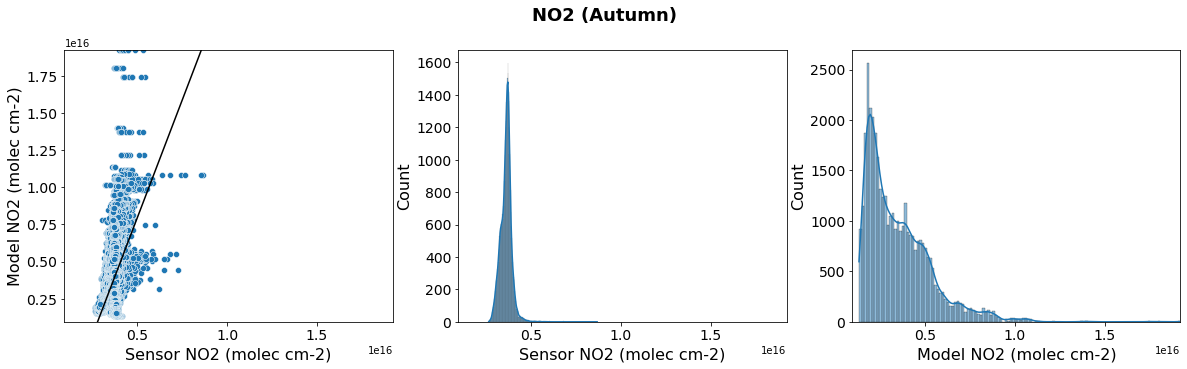

In [19]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual
summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, 
                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, plot_bbox)

In [20]:
summary

,Period,Location,Score,Coefficient,Intercept
0,Summer,"((-20, 30), (40, 70))",0.248274,2.032139,-4.563971e+15
1,Autumn,"((-20, 30), (40, 70))",0.289794,3.163381,-7.890661e+15


## 10. Scatter plots by country (Google API required!)

In [21]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual
plot_countries = ['France', 'Germany', 'Italy']
summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, 
                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, plot_countries)
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'individual' # aggregated or individual\nplot_countries = ['France', 'Germany', 'Italy']\nsummary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, \n                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, plot_countries)\n"

In [22]:
#summary